In [12]:
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import warnings
from acpi.utils import compute_coverage
from acpi import ACPI


warnings.filterwarnings("ignore")

test_ratio = 0.25
calibration_ratio = 0.5
alpha = 0.1

sklearn_data = fetch_california_housing()
X, y = sklearn_data.data, sklearn_data.target


In [13]:
res = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    x_train, x_cal, y_train, y_cal = train_test_split(x_train, y_train, test_size=calibration_ratio)
    model = XGBRegressor()
    model.fit(x_train, y_train)

    # It has the same params as a Random Forest, and it should be tuned to predict the score of calibration set.
    acpi = ACPI(model_cali=model, n_estimators=100, max_depth=20, min_node_size=10)

    acpi.fit(x_cal, y_cal, nonconformity_func=None)
    # You can use custom nonconformity score by using the argument 'nonconformity_func'.
    # It takes a callable[[ndarray, ndarray], ndarray] that return the nonconformity
    # score given (predictions, y_true). By the default, it uses absolute residual if the model
    # is mean estimates and max(pred_lower - y, y - pred_upper) if the model is quantile estimates.

    v_cal = acpi.nonconformity_score(model.predict(x_cal), y_cal)

    acpi.fit_calibration(x_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)
    y_lower, y_upper = acpi.predict_pi(x_test, method='qrf')


    coverage_qrf = compute_coverage(
        y_test,
        y_lower,
        y_upper)

    res.append(coverage_qrf)
    print(f'Coverage QRF at {i} = ', coverage_qrf)

100%|██████████| 50/50 [03:41<00:00,  4.44s/it]


Coverage QRF at 0 =  0.8887596899224807


100%|██████████| 50/50 [03:48<00:00,  4.58s/it]


Coverage QRF at 1 =  0.8959302325581395


100%|██████████| 50/50 [04:02<00:00,  4.85s/it]


Coverage QRF at 2 =  0.9025193798449612


100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


Coverage QRF at 3 =  0.8922480620155039


100%|██████████| 50/50 [04:03<00:00,  4.86s/it]


Coverage QRF at 4 =  0.8996124031007752


100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


Coverage QRF at 5 =  0.8965116279069767


100%|██████████| 50/50 [04:03<00:00,  4.87s/it]


Coverage QRF at 6 =  0.8936046511627908


100%|██████████| 50/50 [03:53<00:00,  4.68s/it]


Coverage QRF at 7 =  0.9003875968992248


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]


Coverage QRF at 8 =  0.8959302325581395


100%|██████████| 50/50 [03:30<00:00,  4.20s/it]


Coverage QRF at 9 =  0.9038759689922481


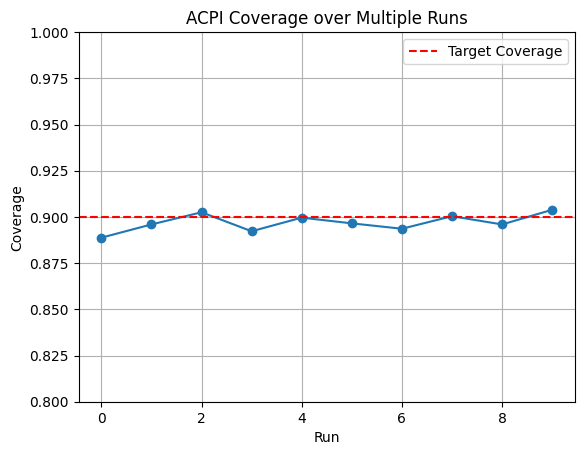

In [14]:
# plot the results
import matplotlib.pyplot as plt
plt.plot(range(10), res, marker='o')
plt.axhline(y=1-alpha, color='r', linestyle='--', label='Target Coverage')
plt.title('ACPI Coverage over Multiple Runs')
plt.xlabel('Run')
plt.ylabel('Coverage')
plt.ylim(0.8, 1)
plt.legend()
plt.grid()
plt.show()


# Coverage outlier percentage
The goal is to check how many times the coverage is above and below the target coverage.

In [ ]:
import math, random, numpy as np, pandas as pd, torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from acpi import ACPI
from acpi.utils import compute_coverage

# ------------------
# Data utilities
# ------------------
def read_data(file):
    df = pd.read_csv(file, parse_dates=["datetime"]).set_index("datetime").sort_index()
    for bcol in ["holiday", "workingday"]:
        if bcol in df.columns:
            df[bcol] = df[bcol].astype(bool)
    df = df.fillna(method='ffill').fillna(method='bfill')
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

def create_sequences(data, context_length, prediction_length):
    X, y = [], []
    for i in range(len(data) - context_length - prediction_length + 1):
        X.append(data[i:i+context_length])
        y.append(data[i+context_length:i+context_length+prediction_length])
    return np.array(X), np.array(y)

def prepare_acpi_data(data, context_length, prediction_length=1, test_split=0.3, cal_split=0.5):
    X, y = create_sequences(data, context_length, prediction_length)
    n_test = int(len(X) * test_split)
    X_temp, X_test = X[:-n_test], X[-n_test:]
    y_temp, y_test = y[:-n_test], y[-n_test:]
    n_cal = int(len(X_temp) * cal_split)
    X_train, X_cal = X_temp[:-n_cal], X_temp[-n_cal:]
    y_train, y_cal = y_temp[:-n_cal], y_temp[-n_cal:]
    return X_train, X_cal, X_test, y_train.flatten(), y_cal.flatten(), y_test.flatten()

# ------------------
# Model definitions
# ------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward,
                 dropout, context_length, prediction_length, output_variance=True):
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.output_variance = output_variance
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=context_length)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        out_dim = prediction_length * (2 if output_variance else 1)
        self.head = nn.Linear(d_model, out_dim)
    def forward(self, x):
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)
        h_last = h[:, -1, :]
        out = self.head(h_last)
        if self.output_variance:
            mean, log_var = out.chunk(2, dim=-1)
            mean = mean.view(-1, self.prediction_length)
            log_var = log_var.view(-1, self.prediction_length).clamp(-7, 7)
            return mean, log_var
        return out.view(-1, self.prediction_length), None

class TransformerACPIWrapper:
    def __init__(self, transformer_model, device):
        self.model = transformer_model.eval()
        self.device = device
    def predict(self, X):
        with torch.no_grad():
            t = torch.as_tensor(X, dtype=torch.float32, device=self.device).unsqueeze(-1)
            mean, _ = self.model(t)
            return mean.cpu().numpy().flatten()

# ------------------
# Training function
# ------------------
def train_transformer(train_series, context_length, prediction_length,
                      device, epochs=5, batch_size=32, lr=1e-3, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    model = TransformerTimeSeriesModel(
        input_size=1, d_model=64, nhead=4, num_layers=2,
        dim_feedforward=128, dropout=0.1,
        context_length=context_length, prediction_length=prediction_length,
        output_variance=True).to(device)
    X, y = create_sequences(train_series, context_length, prediction_length)
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y_t = torch.tensor(y, dtype=torch.float32)
    loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        model.train()
        for bx, by in loader:
            bx, by = bx.to(device), by.to(device)
            opt.zero_grad()
            mean_pred, log_var = model(bx)
            var = torch.exp(log_var)
            loss = 0.5 * (torch.log(2 * math.pi * var) + (by - mean_pred)**2 / var).mean()
            loss.backward()
            opt.step()
    return model

# ------------------
# Multi-run experiment
# ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_df = read_data("data/train.csv")
target_col = "count"
series = train_df[target_col].values.astype(float)

context_length = 24
prediction_length = 1
alpha = 0.1
target_coverage = 1 - alpha
num_runs = 10
epochs_per_run = 5
tolerance = 0.0

coverages = []
run_info = []

for run in range(num_runs):
    seed = 1000 + run
    model = train_transformer(series, context_length, prediction_length,
                              device, epochs=epochs_per_run, seed=seed)
    X_tr, X_cal, X_test, y_tr, y_cal, y_test = prepare_acpi_data(series, context_length, prediction_length)
    wrapper = TransformerACPIWrapper(model, device)
    acpi = ACPI(model_cali=wrapper, n_estimators=100, max_depth=20, min_node_size=10)
    acpi.fit(X_cal, y_cal, nonconformity_func=None)
    acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)
    y_lower, y_upper = acpi.predict_pi(X_test, method='qrf')
    cov = compute_coverage(y_test, y_lower, y_upper)
    coverages.append(cov)
    status = "below" if cov < target_coverage - tolerance else ("above" if cov > target_coverage + tolerance else "on")

    # measure how many times the ture value was above or below the prediction interval
    n_below = (y_test < y_lower).sum()
    n_above = (y_test > y_upper).sum()
    n_within = ((y_test >= y_lower) & (y_test <= y_upper)).sum()
    total = len(y_test)

    run_info.append((run, cov, n_above, n_below, n_within, status))


    print(f"Run {run}: coverage={cov:.4f} (above={n_above}, below={n_below}, within={n_within}, total={total}) - Status: {status}")



# ------------------
# Outlier summary
# ------------------
below = sum(1 for _, _, s in run_info if s == "below")
above = sum(1 for _, _, s in run_info if s == "above")
on = sum(1 for _, _, s in run_info if s == "on")
print(f"Below: {below}, Above: {above}, On-target: {on}")



# ------------------
# Plots
# ------------------
plt.figure(figsize= (10,4))
plt.plot(range(num_runs), coverages, marker='o', label='Coverage')
plt.axhline(target_coverage, color='r', linestyle='--', label='Target')
plt.title('ACPI Coverage per Run (Transformer)')
plt.xlabel('Run')
plt.ylabel('Coverage')
plt.ylim(min(coverages)-0.02, max(coverages)+0.02)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Scatter with color coding
color_map = {"below":"red","above":"green","on":"gray"}
plt.figure(figsize=(10,4))
for run, cov, status in run_info:
    plt.scatter(run, cov, color=color_map[status], s=60)
plt.axhline(target_coverage, color='black', linestyle='--')
plt.title('Coverage Classification per Run')
plt.xlabel('Run')
plt.ylabel('Coverage')
plt.grid(alpha=0.3)
plt.tight_layout()

# Bar chart of outlier counts
plt.figure(figsize=(6,4))
plt.bar(['Below','On','Above'], [below, on, above], color=['red','gray','green'])
plt.title('Run Coverage Status Counts')
plt.ylabel('Count')
plt.tight_layout()

# Histogram of coverage values
plt.figure(figsize=(8,4))
plt.hist(coverages, bins=8, color='steelblue', edgecolor='black')
plt.axvline(target_coverage, color='r', linestyle='--', label='Target')
plt.title('Coverage Distribution')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: dataframe of results
results_df = pd.DataFrame(run_info, columns=['run','coverage','status'])
print(results_df)

100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


Run 0: coverage=0.8573 (above=306, below=159, within=2793, total=3258) - Status: below


100%|██████████| 50/50 [14:39<00:00, 17.59s/it] 


Run 1: coverage=0.8692 (above=293, below=133, within=2832, total=3258) - Status: below


In [17]:
run_info

[(0,
  np.float64(0.8572744014732965),
  np.int64(306),
  np.int64(159),
  np.int64(2793),
  'below'),
 (1,
  np.float64(0.8692449355432781),
  np.int64(293),
  np.int64(133),
  np.int64(2832),
  'below'),
 (2,
  np.float64(0.874462860650706),
  np.int64(228),
  np.int64(181),
  np.int64(2849),
  'below'),
 (3,
  np.float64(0.8422344996930632),
  np.int64(333),
  np.int64(181),
  np.int64(2744),
  'below'),
 (4,
  np.float64(0.8588090853284224),
  np.int64(269),
  np.int64(191),
  np.int64(2798),
  'below'),
 (5,
  np.float64(0.885512584407612),
  np.int64(182),
  np.int64(191),
  np.int64(2885),
  'below'),
 (6,
  np.float64(0.8667894413750767),
  np.int64(241),
  np.int64(193),
  np.int64(2824),
  'below'),
 (7,
  np.float64(0.8741559238796808),
  np.int64(131),
  np.int64(279),
  np.int64(2848),
  'below'),
 (8,
  np.float64(0.8572744014732965),
  np.int64(177),
  np.int64(288),
  np.int64(2793),
  'below'),
 (9,
  np.float64(0.8465316144874155),
  np.int64(294),
  np.int64(206),
  

In [20]:
# Save the run information to a CSV file
run_info_df = pd.DataFrame(run_info, columns=['run', 'coverage', 'n_above', 'n_below', 'n_within', 'status'])
run_info_df.to_csv('transformer_acpi_run_info.csv', index=False)

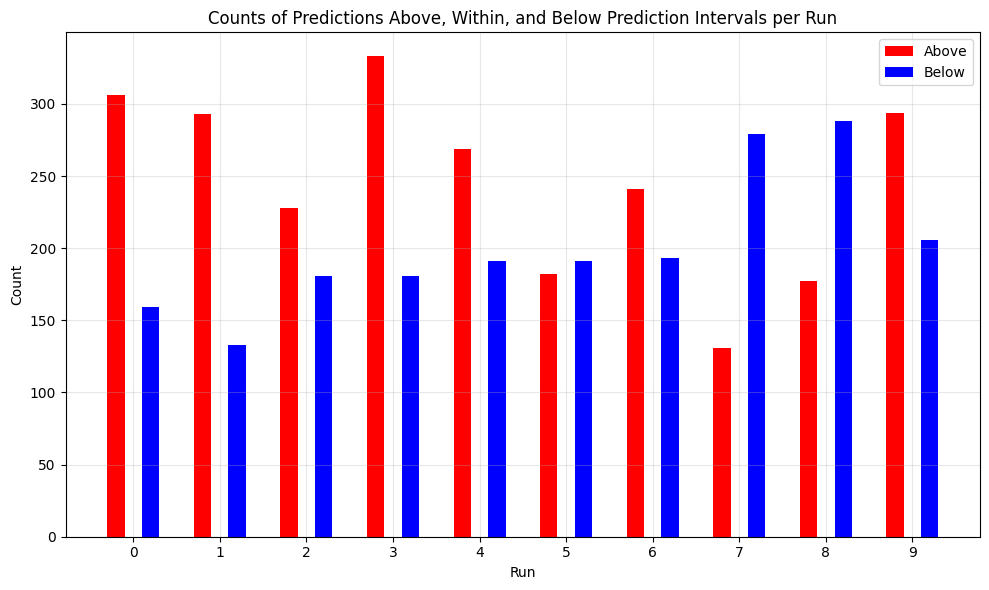

In [22]:
# plot the n_above, n_below, n_within for each run
plt.figure(figsize=(10,6))
width = 0.2
x = np.arange(len(run_info))
n_above = [info[2] for info in run_info]
n_below = [info[3] for info in run_info]
plt.bar(x - width, n_above, width, label='Above', color='red')
plt.bar(x + width, n_below, width, label='Below', color='blue')
plt.xlabel('Run')
plt.ylabel('Count')
plt.title('Counts of Predictions Above, Within, and Below Prediction Intervals per Run')
plt.xticks(x, [info[0] for info in run_info])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()